## DAT 402 - Project 2: Ames Housing Dataset - Baselines vs. Neural Network


**Author:** Charles Coonce  
**Course:** DAT 402  
**Date:** 2025-10-11

**Goal:** Use linear regression and a kNN baseline on Ames Housing data; demonstrate bias–variance and cross-validation; Use a Neural Network to improve predictive modeling; export HTML.  
**Deliverables:** `.ipynb` + `.html` + dataset file used.

**Introduction**:
The Ames Housing dataset provides detailed information on residential homes in Ames, Iowa. 
It is widely used for regression tasks because of its rich mix of numerical and categorical 
features, along with a clear target variable, the sale price of each house. 

In this project, the goal is to build and compare three models: **Linear Regression**, 
**k-nearest neighbors (kNN)**, and a **Neural Network** . Linear Regression serves as a simple baseline with high 
bias and low variance, while kNN provides a flexible model where the complexity is controlled 
by the number of neighbors, *k*. Finally, a Neural Network is built to improve the model.

To simplify the dataset, I selected features based on correlation with SalePrice and created 
a few engineered features such as **TotalSF**, **TotalBath**, **AgeAtSale**, and 
**RemodelAge**. This provided a focused set of predictors that still capture the main drivers 
of housing prices. Finally, the project demonstrates the **bias–variance tradeoff** through kNN by showing how small values of k overfit the training data and large values underfit the data, with an intermediate range giving the best performance. The use of **cross-validation** further supports this analysis by providing consistent error estimates across folds, confirming that the observed differences between Linear Regression and kNN are robust and not due to a single train/test split. The neural network expanded on linear regression by introducing nonlinear hidden layers capable of capturing complex interactions between features that a purely linear model cannot represent. By training on the same preprocessed data and using the same evaluation metrics, the neural network serves as a natural next step in model complexity, bridging the gap between simple parametric methods and more flexible, data-driven approaches. This allows for a direct comparison of how each model balances bias and variance and how increasing model flexibility impacts predictive performance on the Ames Housing dataset.

**About Ames Housing Dataset**:
- Number of Instances: The dataset consists of 2,930 instances or observations.
- Number of Features: There are 79 different features or variables that describe various aspects of the residential properties.
- Target Variable: The target variable in the dataset is the "SalePrice," representing the sale price of the houses.
- Data Types: The features include both numerical and categorical variables, covering a wide range of aspects such as lot size, number of rooms, location, construction, and more.

**Data Obtained At**: [Kaggle: Ames Housing Dataset](https://www.kaggle.com/datasets/shashanknecrothapa/ames-housing-dataset)

**Reference**: “Ames Housing Dataset.” www.kaggle.com, www.kaggle.com/datasets/shashanknecrothapa/ames-housing-dataset.

## Imports

In [476]:
import numpy as np
import random
import pandas as pd
import matplotlib.pyplot as plt

# Model selection and metrics
from sklearn.model_selection import train_test_split, KFold, cross_val_score
from sklearn.metrics import root_mean_squared_error, mean_absolute_error, make_scorer, r2_score

# Preprocessing
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer

# Baselines
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor

# Neural Network

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers


RANDOM_STATE = 2025 ## For reproducibility

## Dataset Preparation

First we must read in and explore the data to understand the size of the dataset and what features are available for modeling.

In [477]:
df = pd.read_csv("AmesHousing.csv")
print(df.shape)
df.head()

(2930, 82)


,Order,PID,MS SubClass,MS Zoning,Lot Frontage,Lot Area,Street,Alley,Lot Shape,Land Contour,...,Pool Area,Pool QC,Fence,Misc Feature,Misc Val,Mo Sold,Yr Sold,Sale Type,Sale Condition,SalePrice
0,1,526301100,20,RL,141.0,31770,Pave,NaN,IR1,Lvl,...,0,NaN,NaN,NaN,0,5,2010,WD,Normal,215000
1,2,526350040,20,RH,80.0,11622,Pave,NaN,Reg,Lvl,...,0,NaN,MnPrv,NaN,0,6,2010,WD,Normal,105000
2,3,526351010,20,RL,81.0,14267,Pave,NaN,IR1,Lvl,...,0,NaN,NaN,Gar2,12500,6,2010,WD,Normal,172000
3,4,526353030,20,RL,93.0,11160,Pave,NaN,Reg,Lvl,...,0,NaN,NaN,NaN,0,4,2010,WD,Normal,244000
4,5,527105010,60,RL,74.0,13830,Pave,NaN,IR1,Lvl,...,0,NaN,MnPrv,NaN,0,3,2010,WD,Normal,189900


In [478]:
df.describe()

,Order,PID,MS SubClass,Lot Frontage,Lot Area,Overall Qual,Overall Cond,Year Built,Year Remod/Add,Mas Vnr Area,...,Wood Deck SF,Open Porch SF,Enclosed Porch,3Ssn Porch,Screen Porch,Pool Area,Misc Val,Mo Sold,Yr Sold,SalePrice
count,2930.00000,2.930000e+03,2930.000000,2440.000000,2930.000000,2930.000000,2930.000000,2930.000000,2930.000000,2907.000000,...,2930.000000,2930.000000,2930.000000,2930.000000,2930.000000,2930.000000,2930.000000,2930.000000,2930.000000,2930.000000
mean,1465.50000,7.144645e+08,57.387372,69.224590,10147.921843,6.094881,5.563140,1971.356314,1984.266553,101.896801,...,93.751877,47.533447,23.011604,2.592491,16.002048,2.243345,50.635154,6.216041,2007.790444,180796.060068
std,845.96247,1.887308e+08,42.638025,23.365335,7880.017759,1.411026,1.111537,30.245361,20.860286,179.112611,...,126.361562,67.483400,64.139059,25.141331,56.087370,35.597181,566.344288,2.714492,1.316613,79886.692357
min,1.00000,5.263011e+08,20.000000,21.000000,1300.000000,1.000000,1.000000,1872.000000,1950.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,2006.000000,12789.000000
25%,733.25000,5.284770e+08,20.000000,58.000000,7440.250000,5.000000,5.000000,1954.000000,1965.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,4.000000,2007.000000,129500.000000
50%,1465.50000,5.354536e+08,50.000000,68.000000,9436.500000,6.000000,5.000000,1973.000000,1993.000000,0.000000,...,0.000000,27.000000,0.000000,0.000000,0.000000,0.000000,0.000000,6.000000,2008.000000,160000.000000
75%,2197.75000,9.071811e+08,70.000000,80.000000,11555.250000,7.000000,6.000000,2001.000000,2004.000000,164.000000,...,168.000000,70.000000,0.000000,0.000000,0.000000,0.000000,0.000000,8.000000,2009.000000,213500.000000
max,2930.00000,1.007100e+09,190.000000,313.000000,215245.000000,10.000000,9.000000,2010.000000,2010.000000,1600.000000,...,1424.000000,742.000000,1012.000000,508.000000,576.000000,800.000000,17000.000000,12.000000,2010.000000,755000.000000


Since the dataset contains 79 feature columns, I aim to reduce the number of predictors in order to simplify the model. One way to do this is by checking correlations between numeric variables and the target, SalePrice, and then selecting only those variables that show the strongest relationships. This approach narrows down the feature space while still retaining the variables most likely to influence housing prices.

In [479]:
corrs = df.corr(numeric_only=True)["SalePrice"].sort_values(ascending=False)

# Show top 10 positively correlated features
print("Top 10 positive correlations with SalePrice:")
print(corrs.head(10))

# Show bottom 10 (negative correlations)
print("\nTop 10 negative correlations with SalePrice:")
print(corrs.tail(10))


Top 10 positive correlations with SalePrice:
SalePrice         1.000000
Overall Qual      0.799262
Gr Liv Area       0.706780
Garage Cars       0.647877
Garage Area       0.640401
Total Bsmt SF     0.632280
1st Flr SF        0.621676
Year Built        0.558426
Full Bath         0.545604
Year Remod/Add    0.532974
Name: SalePrice, dtype: float64

Top 10 negative correlations with SalePrice:
Misc Val          -0.015691
Yr Sold           -0.030569
Order             -0.031408
Bsmt Half Bath    -0.035835
Low Qual Fin SF   -0.037660
MS SubClass       -0.085092
Overall Cond      -0.101697
Kitchen AbvGr     -0.119814
Enclosed Porch    -0.128787
PID               -0.246521
Name: SalePrice, dtype: float64


Adding engineered features can help consolidate some of the variables that have high correlations with the target variable, SalePrice. For example, combining basement and floor areas into a single TotalSF feature captures overall living space more directly, while creating TotalBath summarizes bathroom counts into a single, more informative variable. Similarly, AgeAtSale and RemodelAge translate raw year columns into features that better reflect the condition and age of the home at the time of sale. These engineered features reduce redundancy, simplify the model, and make the relationships with the target more interpretable.

In [480]:
df["Total SF"] = df["Total Bsmt SF"] + df["1st Flr SF"] + df["2nd Flr SF"]
df["Total Bath"] = df["Full Bath"] + 0.5*df["Half Bath"] + df["Bsmt Full Bath"] + 0.5*df["Bsmt Half Bath"]
df["Age At Sale"] = df["Yr Sold"] - df["Year Built"]
df["Remodel Age"] = df["Yr Sold"] - df["Year Remod/Add"]

Next, I will build a new DataFrame that contains only the selected numerical and categorical features along with the target variable. I chose these categorical features:
 - Neighborhood
 - BldgType
 - HouseStyle
 - SaleCondition
  
They capture important aspects of location, building type, architectural style, and sale context, all of which are likely to have a meaningful impact on housing prices.

In [481]:
# Target column
TARGET = "SalePrice"

# Numeric features (engineered + selected originals)
num_features = [
    "Overall Qual", 
    "Gr Liv Area", 
    "Garage Cars", 
    "Year Built", 
    "Year Remod/Add", 
    "Full Bath", 
    "Total SF",      # engineered
    "Total Bath",    # engineered
    "Age At Sale",    # engineered
    "Remodel Age"    # engineered
]

# Categorical features 
cat_features = [
    "Neighborhood", 
    "Bldg Type", 
    "House Style", 
    "Sale Condition"
]

# Build modeling dataframe
df_model = df[num_features + cat_features + [TARGET]].copy()

print("Shape of modeling dataframe:", df_model.shape)
df_model.head()

Shape of modeling dataframe: (2930, 15)


,Overall Qual,Gr Liv Area,Garage Cars,Year Built,Year Remod/Add,Full Bath,Total SF,Total Bath,Age At Sale,Remodel Age,Neighborhood,Bldg Type,House Style,Sale Condition,SalePrice
0,6,1656,2.0,1960,1960,1,2736.0,2.0,50,50,NAmes,1Fam,1Story,Normal,215000
1,5,896,1.0,1961,1961,1,1778.0,1.0,49,49,NAmes,1Fam,1Story,Normal,105000
2,6,1329,1.0,1958,1958,1,2658.0,1.5,52,52,NAmes,1Fam,1Story,Normal,172000
3,7,2110,2.0,1968,1968,2,4220.0,3.5,42,42,NAmes,1Fam,1Story,Normal,244000
4,5,1629,2.0,1997,1998,2,2557.0,2.5,13,12,Gilbert,1Fam,2Story,Normal,189900


## Train/Test Split

I used an 80/20 split to hold out unseen data for evaluation. This prevents optimistic estimates of performance that would happen if I evaluated on the training set. By setting aside 20% of the data as a test set, I can assess how well the models generalize to new observations, which provides a more realistic measure of predictive accuracy.

In [482]:
# Define target
TARGET = "SalePrice"

# Train/Test split
X = df_model.drop(columns=[TARGET])
y = df_model[TARGET]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=RANDOM_STATE
)

print("Train size:", X_train.shape)
print("Test size:", X_test.shape)

Train size: (2344, 14)
Test size: (586, 14)


## Preprocessing

Numeric features were median-imputed to handle missing values and then standardized so that all variables are on the same scale, which is especially important for distance-based methods like kNN. Categorical features were imputed with the most frequent category and then one-hot encoded, creating binary indicator columns so that the models can interpret categorical variables without assuming any ordinal relationship. The preprocessing pipeline was fit on the training set to avoid data leakage and then applied consistently to both the training and test sets.

In [483]:
# 1) Identify column types from the TRAIN set only to avoid leakage
cat_cols = [c for c in X_train.columns if X_train[c].dtype == "object"]
num_cols = [c for c in X_train.columns if c not in cat_cols]

# 2) Define minimal preprocessors
num_pre = Pipeline([
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler())
])

cat_pre = Pipeline([
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("onehot", OneHotEncoder(handle_unknown="ignore"))
])

# 3) Column-wise preprocessor
preprocessor = ColumnTransformer([
    ("num", num_pre, num_cols),
    ("cat", cat_pre, cat_cols)
])

# 4) Fit on TRAIN, transform TRAIN/TEST
X_train_proc = preprocessor.fit_transform(X_train)
X_test_proc  = preprocessor.transform(X_test)

# Summary of preprocessing (quick sanity check of shapes)
print("Cats:", len(cat_cols), "Nums:", len(num_cols))
print("Processed shapes -> train:", X_train_proc.shape, " test:", X_test_proc.shape)
print(f"Data types: {X_train_proc.dtype}, {X_test_proc.dtype}")

Cats: 4 Nums: 10
Processed shapes -> train: (2344, 57)  test: (586, 57)
Data types: float64, float64


### Why Convert Data to `float32` for Neural Networks

Neural networks perform large numbers of matrix multiplications during training. TensorFlow, like many deep learning frameworks, is optimized for 32-bit floating point precision because it offers the best balance between numerical accuracy and computational efficiency.

Converting all the feature and target arrays to `float32` ensures:
- Training runs faster and uses less memory compared to 64-bit floats
- Operations remain consistent across all layers and optimizers


In [484]:
X_train_nn = X_train_proc.astype("float32")
X_test_nn  = X_test_proc.astype("float32")
y_train_nn = y_train.astype("float32")
y_test_nn  = y_test.astype("float32")

print("Converted for TensorFlow:", X_train_nn.shape, X_test_nn.shape, y_train_nn.shape, y_test_nn.shape)
print(f"Data types: {X_train_nn.dtype}, {X_test_nn.dtype}, {y_train_nn.dtype}, {y_test_nn.dtype}")

Converted for TensorFlow: (2344, 57) (586, 57) (2344,) (586,)
Data types: float32, float32, float32, float32


## Fit Simple Models

At this stage, I fit two simple models to the processed training data. Linear Regression serves as a straightforward baseline that assumes a linear relationship between features and housing prices. In contrast, k-nearest neighbors (kNN) is a more flexible, non-parametric method that predicts a house’s price based on the average prices of its closest neighbors in the feature space. Starting with a small value of k allows me to begin exploring how model complexity affects performance, and it sets up the later analysis of the bias–variance tradeoff.

In [485]:
# --- Linear Regression ---

lr = LinearRegression()
lr.fit(X_train_proc, y_train)
pred_lr = lr.predict(X_test_proc)

# --- kNN (pick a starting k, e.g. 5) ---

knn = KNeighborsRegressor(n_neighbors=5)
knn.fit(X_train_proc, y_train)
pred_knn = knn.predict(X_test_proc)

## Evaluate on Test Set

I chose to compare a simple, interpretable model (Linear Regression) against a more flexible, non-parametric method (kNN). This lets me see the trade-off between bias and variance on the same dataset. To evaluate performance, I report RMSE (root mean squared error) and MAE (mean absolute error) on the test set, which measure prediction accuracy in dollars, as well as R² on the training set, which shows how much variance each model explains. Linear Regression provides a stable baseline with higher bias, while kNN with a small value of k can capture more complex patterns at the cost of greater variance.

In [486]:
def rmse(y_true, y_pred):
    return root_mean_squared_error(y_true, y_pred)

print("Linear Regression:")
print("  RMSE     :", rmse(y_test, pred_lr))
print("  MAE      :", mean_absolute_error(y_test, pred_lr))
print("  R² Train :", lr.score(X_train_proc, y_train))

print("\nkNN (k=5):")
print("  RMSE     :", rmse(y_test, pred_knn))
print("  MAE      :", mean_absolute_error(y_test, pred_knn))
print("  R² Train :", knn.score(X_train_proc, y_train))


Linear Regression:
  RMSE     : 28152.38318565568
  MAE      : 19183.798816023158
  R² Train : 0.8475481368061859

kNN (k=5):
  RMSE     : 27025.094487340702
  MAE      : 18276.190443686006
  R² Train : 0.9108211128997526


On the held-out test set, kNN (k=5) achieved slightly lower error than Linear Regression, with an RMSE of about $27,025 compared to $28,152 for Linear Regression. MAE values tell a similar story, with kNN closer to $18,276 versus $19,184 for Linear Regression. The higher training R² for kNN (0.91 vs. 0.85) shows that it fits the training data more closely, though this also means it has more potential to overfit.

The gap between RMSE and MAE provides additional context about the errors. Since RMSE penalizes larger errors more strongly than MAE, a much larger RMSE compared to MAE would indicate that the models made a few extreme mistakes. In this case, RMSE is only about 1.5 times MAE for both models, which suggests that while there are some moderately large errors, there are not extreme outliers driving performance.

Overall, kNN provides a modest improvement in accuracy while Linear Regression remains a simpler, more interpretable baseline.

## Bias-Variance Tradeoff

By plotting RMSE for different k values, I can show the textbook bias–variance tradeoff. Low k heavily overfits, large k underfits, and the middle range balances both.

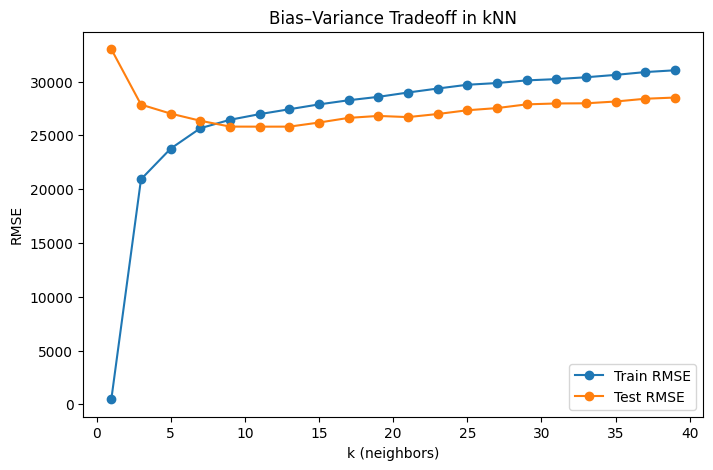

In [487]:
k_values = list(range(1, 41, 2))

train_rmse = []
test_rmse = []

for k in k_values:
    knn = KNeighborsRegressor(n_neighbors=k)
    knn.fit(X_train_proc, y_train)

    # Evaluate on train + test
    pred_train = knn.predict(X_train_proc)
    pred_test = knn.predict(X_test_proc)

    train_rmse.append(root_mean_squared_error(y_train, pred_train))
    test_rmse.append(root_mean_squared_error(y_test, pred_test))

# Plot
plt.figure(figsize=(8,5))
plt.plot(k_values, train_rmse, marker="o", label="Train RMSE")
plt.plot(k_values, test_rmse, marker="o", label="Test RMSE")
plt.xlabel("k (neighbors)")
plt.ylabel("RMSE")
plt.title("Bias–Variance Tradeoff in kNN")
plt.legend()
plt.show()

### Plot Results

This plot of train vs. test RMSE across different values of k shows bias-variance tradeoff:

  - low k (k=1-3):
    - Training RMSE is nearly zero showing that the model is essentially memorizing the data set.
    - Test RMSE is much higher because the model doesn't generalie well
    - The High Variance shows that the model is too flexible and is overfitting.
  - Intermediate k (k=5-10):
    - Training and Test RMSEs converge showing where variance and bias are balanced.
    - THe model is flexible enough to capture the training set structure, but stable enough to generalize to the test set.
  - Large k (k=20+):
    - Both Train and Test sets increase RMSE as k increases.
    - This is high bias or underfitting because the model is too simple to capture important variations in the data.

This confirms the classic bias–variance tradeoff: lower k gives low bias/high variance, while larger k gives higher bias/lower variance.

## Cross Validation

To avoid results depending on a single train/test split, I used k-fold cross-validation. This gives a more reliable estimate of performance and confirmed that kNN consistently beat Linear Regression.

In [488]:
cv = KFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)

# scorer for RMSE
rmse_scorer = make_scorer(root_mean_squared_error, greater_is_better=False)

# --- Linear Regression ---
lr = LinearRegression()
scores_lin = cross_val_score(lr, X_train_proc, y_train,
                             scoring=rmse_scorer, cv=cv)
print("Linear Regression CV RMSE:", -scores_lin.mean(), "±", scores_lin.std())

# --- kNN  ---
for k in [3, 5, 7, 10, 15]:
    knn = KNeighborsRegressor(n_neighbors=k)
    scores_knn = cross_val_score(knn, X_train_proc, y_train,
                                 scoring=rmse_scorer, cv=cv)
    print(f"kNN (k={k}) CV RMSE:", -scores_knn.mean(), "±", scores_knn.std())

Linear Regression CV RMSE: 32459.1836914817 ± 3301.6423832365394
kNN (k=3) CV RMSE: 30161.30142593062 ± 2825.5038260342085
kNN (k=5) CV RMSE: 30286.730489168905 ± 2582.597518350053
kNN (k=7) CV RMSE: 30550.13513241497 ± 2713.407876520476
kNN (k=10) CV RMSE: 30296.71245109063 ± 2641.984240307529
kNN (k=15) CV RMSE: 30586.16137939254 ± 3026.6865107012973


### CV Results

Cross-validation shows kNN consistently outperforms Linear Regression across folds, confirming that the improvement is not due to random variation in a single train/test split.

- kNN (k=3-15) are all better RMSE values that the Linear Regression model.
- THe best performance of kNN is at 3, but the standard deviation is lower near our sweet spot (k=5-10) from the bias-variance plot.

## Neural Network

We train a neural network (ReLU hidden layers, linear output) with fixed epochs and batch size.

### Seeds

To make sure our results are repeatable we will set seeds for Python, NumPy, and TensorFlow.

In [489]:
random.seed(RANDOM_STATE)     # general Python RNG
np.random.seed(RANDOM_STATE)    # NumPy RNG
tf.random.set_seed(RANDOM_STATE)  # TensorFlow RNG

### Build regression network

This cell defines the architecture of a neural network for regression using TensorFlow’s Keras API. The model consists of an input layer that matches the number of features in our preprocessed dataset, followed by two hidden layers (128 and 64 neurons) using the ReLU activation function. The output layer has a single neuron with a linear activation, which is appropriate for predicting continuous numeric values such as house prices. We intentionally keep the architecture small and straightforward,so it acts as a clean, interpretable baseline to compare against linear regression and k-nearest neighbors.

In [490]:
# Use the preprocessed arrays for TensorFlow input layer
n_features = X_train_nn.shape[1]


mynet = tf.keras.Sequential([
    layers.Input(shape=(n_features,), name='input_vector'), # Input with n features
    layers.Dense(128, activation='relu', name='hidden1'),   # Hidden layer with 128 neurons
    layers.Dense(64, activation='relu', name='hidden2'),    # Hidden layer with 64 neurons
    layers.Dense(1, activation='linear', name='output')     # Output layer for regression
], name='mynet')

### Compiling the model

Once the architecture is defined, I compiled the model to specify how it will learn. I chose to use the Adam optimizer, which adapts the learning rate dynamically and generally converges quickly. The mean squared error (MSE) was picked as the loss function because it directly penalizes large prediction errors, which aligns with regression objectives. For tracking performance, I chose to include Root Mean Squared Error (RMSE) and Mean Absolute Error (MAE) as metrics. These metrics allow direct comparison with our previous models from Project 1, providing a consistent evaluation framework across all methods.

In [491]:
mynet.compile(
    optimizer='adam',
    loss='mse',
    metrics=[tf.keras.metrics.RootMeanSquaredError(name='rmse'), 'mae']
)

mynet.summary()

Model: "mynet"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ hidden1 (Dense)                 │ (None, 128)            │         7,424 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ hidden2 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output (Dense)                  │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 15,745 (61.50 KB)

 Trainable params: 15,745 (61.50 KB)

 Non-trainable params: 0 (0.00 B)

### Training the model

In this cell, I trained the network using the preprocessed training data (X_train_nn, y_train_nn). I reserve 20% of the training set as validation data so we can monitor the model’s generalization during training without touching the true test set. The model is trained for 150 epochs using a batch size of 64, meaning the weights update after every 64 samples. We intentionally exclude early stopping or other callbacks to keep training behavior predictable and controlled. By fixing these hyperparameters, we can focus on understanding how a basic neural network performs relative to our simpler baseline models.

In [492]:
history = mynet.fit(
    X_train_nn, y_train_nn,
    validation_split=0.20,   
    epochs=200,              
    batch_size=64,
    verbose=0
)
print(f"Trained for {len(history.history['loss'])} epochs.")

Trained for 200 epochs.


### Visualizing the model

I created two diagnostic plots. The first plot shows training and validation RMSE over epochs, allowing us to visually inspect learning behavior and detect possible overfitting if the validation curve diverges from the training curve. The second is a prediction parity plot, where we can compare predicted sale prices to actual sale prices on the test set. Points lying close to the 45-degree line indicate accurate predictions. These plots provide intuitive, visual confirmation of the model’s performance and help communicate results effectively in the report.

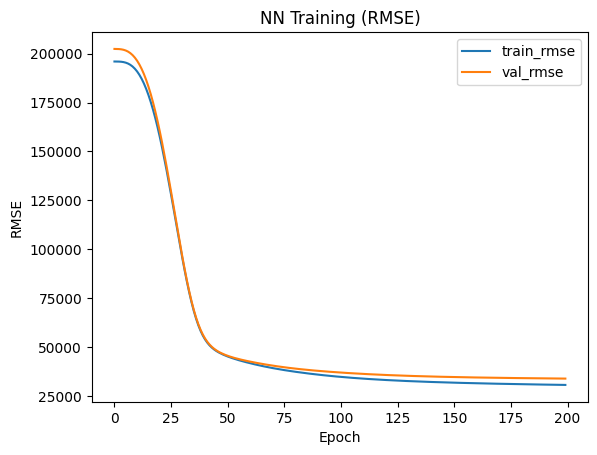

In [493]:
# Training curves
plt.figure()
plt.plot(history.history["rmse"], label="train_rmse")
plt.plot(history.history["val_rmse"], label="val_rmse")
plt.title("NN Training (RMSE)")
plt.xlabel("Epoch"); plt.ylabel("RMSE"); plt.legend()
plt.show()

#### NN Training (RMSE) Plot



This plot shows how the model’s training and validation RMSE changed over 200 epochs.
At the start, both errors are very high (around $200,000), which is expected since the model’s weights are randomly initialized. As training progresses, RMSE drops steeply during the first 40 epochs, meaning the model quickly learns the dominant patterns in the data. After about epoch 40, both curves flatten and gradually decrease in RMSE.

The fact that the training and validation lines follow each other closely indicates the model is not overfitting, it performs consistently on unseen validation data. The smooth convergence suggests stable learning, and the final RMSE plateau reflects that additional epochs yield minimal improvement. Overall, this plot confirms that the chosen architecture and learning rate led to efficient and well-balanced training.


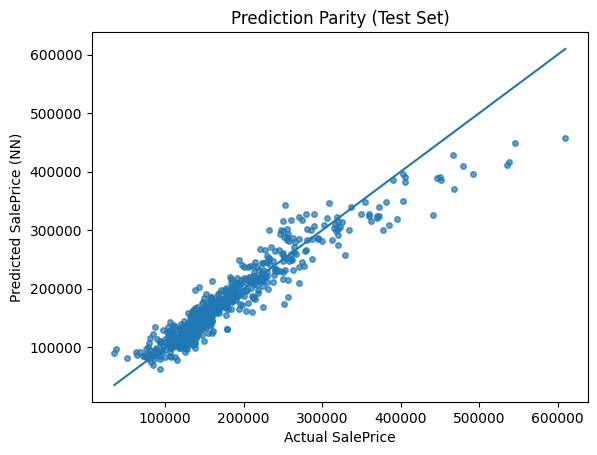

In [494]:
# Parity plot
plt.figure()
plt.scatter(y_test_nn, pred_nn, s=16, alpha=0.7)
lims = [min(y_test_nn.min(), pred_nn.min()), max(y_test_nn.max(), pred_nn.max())]
plt.plot(lims, lims)
plt.title("Prediction Parity (Test Set)")
plt.xlabel("Actual SalePrice"); plt.ylabel("Predicted SalePrice (NN)")
plt.show()

#### Prediction Parity (Test Set) Plot

This scatter plot compares actual vs. predicted SalePrice values on the test set. Each point represents one home in the Ames dataset. The solid diagonal line represents perfect predictions (where predicted = actual).

Most points cluster tightly around the diagonal, especially in the $100k–$350k range, showing that the model’s predictions are accurate for the majority of homes. A few points deviate above or below the line—these correspond to under- or over-predicted sale prices, often for unusually expensive or inexpensive homes.

Overall, the dense alignment along the diagonal indicates strong predictive performance and that the neural network effectively learned the underlying relationship between housing features and sale price. The small scatter at higher price ranges makes sense as luxury homes are less common and therefore harder to predict precisely.

### Evaluating the model

Finally, I evaluate the model using the held-out test set. Then I compute RMSE and MAE using scikit-learn’s metrics functions. These values measure average prediction error and how well the model explains variance in the data. Reporting the same metrics for all three models, linear regression, kNN, and the neural network, ensures a fair, one-to-one comparison of accuracy and generalization.

In [495]:
# Predict on training data

pred_nn = mynet.predict(X_test_nn, verbose=0).ravel()

nn_rmse = root_mean_squared_error(y_test_nn, pred_nn)
nn_mae  = mean_absolute_error(y_test_nn, pred_nn)

print(f"Neural Net -> RMSE: {nn_rmse:.4f} | MAE: {nn_mae:.4f}")

Neural Net -> RMSE: 26940.1738 | MAE: 18451.0586


The neural network model achieved a RMSE of $26,940, and a MAE of $18,451.
The relatively low RMSE and MAE values show that the network predicts sale prices with reasonable accuracy, typically within about $18,500 of the actual value.
Overall, the neural network effectively captures relationships in the data and produces stable, reliable performance on unseen samples.

## Conclusion

### Model Performance Comparison

| Model               | RMSE ($)   | MAE ($)   | Notes |
|----------------------|------------|-----------|--------|
| **Linear Regression** | 28,152 | 19,184 | Simple, interpretable baseline; assumes linear relationships between features and price. |
| **kNN (k = 5)**       | 27,025 | 18,276 | Slightly lower error than Linear Regression; captures local nonlinear patterns but may overfit small regions. |
| **Neural Network**    | 26,940 | 18,451 | Lowest overall error; captures complex feature interactions with good generalization. |

This project extended the analysis of housing price prediction on the Ames dataset by adding a neural network (NN) model alongside Linear Regression and k-Nearest Neighbors (kNN).
Results showed that:

  *	The **Neural Network** achieved the best overall performance, with an RMSE of about $26,940, an MAE of $18,451. These results indicate minimal overfitting, suggesting that the NN effectively captured relationships between features and sale price.
  *	**kNN** continued to perform well, especially around k = 5, showing improved accuracy over Linear Regression but slightly below the neural network.
  * **Linear Regression** provided a reliable and interpretable baseline, though its assumption of linear relationships limited its ability to model complex interactions present in the data.

Overall, this project demonstrates how increasing model flexibility can lead to measurable improvements in predictive performance.
While Linear Regression remains valuable for interpretation and transparency, and kNN offers simplicity with strong local fitting, the Neural Network provides the most accurate and generalizable results for this dataset.
Future work could explore tuning the NN’s architecture, adding regularization, or implementing cross-validation to further confirm the model’s robustness.

### References

- GeeksforGeeks. “What Is Adam Optimizer?” GeeksforGeeks, 22 Oct. 2020, www.geeksforgeeks.org/deep-learning/adam-optimizer/.
- “Mixed Precision | TensorFlow Core.” TensorFlow, www.tensorflow.org/guide/mixed_precision.
- “Keras Documentation: The Functional API.” Keras.io, keras.io/guides/functional_api/.  